# Time-Series Anomaly Detection with LSTM-based Models

This notebook presents a comprehensive framework for anomaly detection in time-series data, demonstrated on the Secure Water Treatment (SWAT) dataset. The project aims to train, evaluate, and compare several deep learning models for their effectiveness in identifying anomalous patterns.

The primary objective is to evaluate different model architectures based on the reconstrcution and LSTM. The models implemented include:
* LSTM-AE
* Attention LSTM-AE
* LSTM-VAE
* Attention LSTM-VAE

Furthermore, for each trained model, the notebook assesses its performance using three different anomaly scoring methods:
* Mean Squared Error (MSE) based on reconstruction loss.
* A statistical method using the Interquartile Range (IQR) of reconstruction errors.
* The Mahalanobis distance, which accounts for correlations between different feature errors.

The performance of each model and scoring method combination is measured using standard classification metrics, including Precision, Recall, F1-score, ROC-AUC, and PR-AUC. The notebook's final output is a summary table that directly compares the results of all approaches. The code is structured into clear sections for configuration, data loading, model definition, training, and evaluation. Key parameters can be easily adjusted in the `Config` class.

## Import Required Libraries
This block imports all the necessary libraries for the project. It includes torch for building and training neural networks, pandas and numpy for data manipulation, scikit-learn for data preprocessing and evaluation metrics, and matplotlib for plotting results.

In [73]:
import time
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import re, ast
from pathlib import Path
import joblib, json, numpy as np
import seaborn as sns
from scipy.stats import genpareto
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_recall_fscore_support, confusion_matrix

warnings.filterwarnings('ignore')

# Try to mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except:
    print("Not in Colab environment")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configuration Class
This cell defines a Config class that contains all hyperparameters and settings for the experiment. It includes dataset selection (SWAT/SMAP/MSL), model parameters (sequence length, batch size, hidden dimensions, LSTM-Layers), training settings (learning rate, epochs, patience for early stopping), and device configuration (GPU/CPU). The adjust_for_dataset function modifies settings based on the selected dataset.

In [74]:
class Config:
    # 'SWAT' / 'SMAP' / 'MSL'
    DATASET   = 'SWAT'
    # DATASET   = 'SMAP'

    MODE = 'train'     # 'train'：train models 'test'：only test, no save
    LOAD_RUN = None    # in train mode, set LOAD_RUN = None

    # MODE = 'test'
    # # LOAD_RUN = "/content/drive/MyDrive/Colab Notebooks/P_Models/SWAT_20250825_125005_seed0"
    # LOAD_RUN = "/content/drive/MyDrive/Colab Notebooks/P_Models/SWAT_res01"
    # LOAD_RUN = "/content/drive/MyDrive/Colab Notebooks/P_Models/SWAT_20250820_225845_seed0"


    # VIS_FEATURES = ['FIT301', 'LIT101', 'MV101', 'P101']  # plot features
    VIS_FEATURES = ['LIT101']  # plot features
    VIS_WINDOW_RANGE = 1000
    VIS_WINDOW_SEQ = 6

    SAVE_CKPT = True # if save model
    SAVE_ARTIFACTS = True # if save result

    VAE_BETA = 1.0    # KL （Beta-VAE）
    VAE_DETERMINISTIC_EVAL = False  # when evaluate, use mu downsampling

    TH_BETA = 3

    DATA_DIR  = Path("/content/drive/MyDrive/Colab Notebooks/P_Dataset")
    SEQ_LEN   = 100
    STRIDE    = 1
    BATCH_SIZE= 64
    HIDDEN_DIM= 64
    NUM_LAYERS= 2
    DROPOUT   = 0.2
    LEARNING_RATE = 1e-3
    NUM_EPOCHS    = 2
    PATIENCE      = 15
    GRADIENT_CLIP = 1.0
    REMOVE_HOURS  = 5   # only SWAT use
    SEED          = 0
    VAL_SPLIT     = 0.2
    THR_STEP = 1000
    ANOMALY_METRICS = ['mse', 'iqr', 'maha']

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def adjust_for_dataset(cfg: Config):
    if cfg.DATASET.upper() in ('SMAP', 'MSL'):
        config.SAVE_CKPT = False
        config.SAVE_ARTIFACTS = False
        cfg.SEQ_LEN = 50    # MSL,SMAP, set SEQ_LEN = 50
        cfg.REMOVE_HOURS = 0


config = Config()
print(f"Using device: {config.DEVICE}")

# ======================== Set Random Seeds ========================
def set_seed(seed=config.SEED):
    """Set all random seeds for reproducibility"""
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

Using device: cuda


## Data Loading Functions
This cell contains functions for loading and preprocessing datasets:
- `load_and_preprocess_swat`: Loads SWaT dataset, removes initial unstable hours, handles timestamp, removes zero-variance features, and applies MinMax scaling
- `load_nasa_channel`: Loads NASA (SMAP/MSL) datasets channel by channel
- `TimeSeriesWindowDataset`: PyTorch Dataset class that creates sliding windows from time series data for training

In [75]:

# ======================== Data Loading ========================
def load_and_preprocess_swat(train_path, test_path, config):
    """Load and preprocess SWaT dataset"""
    print("Loading data...")

    # Load data
    train_df = pd.read_parquet(train_path)
    test_df = pd.read_parquet(test_path)

    if 'Timestamp' in train_df.columns:
        train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'], errors='coerce')
        train_df = train_df.dropna(subset=['Timestamp']).set_index('Timestamp')

    if 'Timestamp' in test_df.columns:
        test_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'], errors='coerce')
        test_df = test_df.dropna(subset=['Timestamp']).set_index('Timestamp')

    # Clean column names
    train_df.columns = train_df.columns.str.strip()
    test_df.columns = test_df.columns.str.strip()

    # Remove first 5 hours of training data (unstable period)
    print(f"Original training data shape: {train_df.shape}")
    samples_per_hour = 3600  # 1 sample per second
    train_df = train_df.iloc[config.REMOVE_HOURS * samples_per_hour:]
    print(f"After removing first {config.REMOVE_HOURS} hours: {train_df.shape}")

    # Separate features and labels
    X_train = train_df.iloc[:, :-1].select_dtypes(include=[np.number])
    X_test = test_df.iloc[:, :-1].select_dtypes(include=[np.number])
    # y_test = (test_df.iloc[:, -1] == ('Attack' or 'A ttack')).astype(int)
    y_test = test_df.iloc[:, -1].isin(['Attack', 'A ttack']).astype(int)


    # #####################################################################
    var_series = X_train.var(axis=0, ddof=0) # remove feature, if var=0
    zero_var_cols = var_series[var_series == 0.0].index.tolist()

    if zero_var_cols:
        print(f"Removing {len(zero_var_cols)} zero-variance features:")
        print(", ".join(zero_var_cols))
        X_train = X_train.drop(columns=zero_var_cols)
        X_test  = X_test.drop(columns=zero_var_cols)
    else:
        print("No zero-variance features found.")
    # #####################################################################

    print(f"Number of features: {X_train.shape[1]}")
    print(f"Feature names: {list(X_train.columns[:-1])}...")

    # Apply MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    # scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to numpy arrays
    X_train_scaled = X_train_scaled.astype(np.float32)
    X_test_scaled = X_test_scaled.astype(np.float32)

    # Remove any NaN values
    X_train_scaled = np.nan_to_num(X_train_scaled, 0)
    X_test_scaled = np.nan_to_num(X_test_scaled, 0)

    feature_names = X_train.columns.tolist()

    return X_train_scaled, X_test_scaled, y_test.values, scaler, feature_names


def load_nasa_channel(root_dir: Path, mission: str, chan_id: str):
    # read on channel, return: X_train 1-D,  X_test 1-D,  y_test 0/1,  scaler

    data_dir = root_dir / f"Dataset_{mission}" / f"data_{mission.lower()}"
    X_tr = np.load(data_dir/'train'/f"{chan_id}.npy").astype(np.float32)
    X_te = np.load(data_dir/'test' /f"{chan_id}.npy").astype(np.float32)

    y_te = np.zeros(len(X_te), dtype=np.int32)
    lbl_df = pd.read_csv(root_dir/'labeled_anomalies_n.csv')
    row = lbl_df[(lbl_df.spacecraft == mission) & (lbl_df.chan_id == chan_id)]
    if not row.empty:
        spans = re.findall(r"\[\s*\d+,\s*\d+\s*\]", row.iloc[0].anomaly_sequences)
        for s, e in map(ast.literal_eval, spans):
            y_te[s:e+1] = 1

    # MinMax
    scaler = MinMaxScaler()
    # scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr).astype(np.float32)
    X_te = scaler.transform(X_te).astype(np.float32)

    return X_tr, X_te, y_te, scaler



# ======================== Dataset Class ========================
class TimeSeriesWindowDataset(Dataset):
    """Dataset for creating sequences from SWaT data"""
    def __init__(self, data, seq_len, stride, labels=None):
        self.data = data
        self.seq_len = seq_len
        self.stride = stride
        self.labels = labels

        # Calculate valid indices
        self.indices = []
        for i in range(0, len(data) - seq_len + 1, stride):
            self.indices.append(i)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_idx = self.indices[idx]
        sequence = self.data[start_idx:start_idx + self.seq_len]

        if self.labels is not None:
            # Point anomaly: if ANY point in window is anomaly
            label = self.labels[start_idx:start_idx + self.seq_len].max()
            return torch.FloatTensor(sequence), label

        return torch.FloatTensor(sequence)

## LSTM-based Model Definitions
This cell defines four different LSTM-based autoencoder architectures:
1. `LSTMAutoencoder`: Basic LSTM encoder-decoder model
2. `AttentionLSTMAutoencoder`: LSTM with self-attention mechanism.
3. `LSTMVAE`: Variational Autoencoder with LSTM for probabilistic modeling
4. `AttentionLSTMVAE`: Combines attention mechanism with VAE structure

Each model compresses input sequences to latent representations and reconstructs them. VAE models additionally learn probabilistic distributions.

In [76]:

# ======================== Model Definitions ========================
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, seq_len, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len

        # Encoder
        self.encoder = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

        # Decoder
        self.decoder = nn.LSTM(
            hidden_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Output projection
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        # Encode
        _, (hidden, cell) = self.encoder(x)

        # Use last hidden state
        hidden_last = hidden[-1]

        # Repeat for sequence length
        decoder_input = hidden_last.unsqueeze(1).repeat(1, self.seq_len, 1)

        # Decode
        # decoder_output, _ = self.decoder(decoder_input)
        # use (hidden, cell) to initialize decoder
        decoder_output, _ = self.decoder(decoder_input, (hidden, cell))  # (B, L, H)

        # Output
        output = self.output_layer(decoder_output)

        return output

class AttentionLSTMAutoencoder(nn.Module):
    """LSTM Autoencoder with Self-Attention"""
    def __init__(self, input_dim, hidden_dim, num_layers, seq_len, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len

        # Encoder
        self.encoder = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Self-attention
        self.attention = nn.MultiheadAttention(
            hidden_dim,
            num_heads=4,
            dropout=dropout,
            batch_first=True
        )

        # Decoder
        self.decoder = nn.LSTM(
            hidden_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Output projection
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        # Encode
        encoder_output, (hidden, cell) = self.encoder(x)

        # Apply self-attention
        attn_output, _ = self.attention(encoder_output, encoder_output, encoder_output)

        # Decode with attention-enhanced features
        # decoder_output, _ = self.decoder(attn_output)
        decoder_output, _ = self.decoder(attn_output, (hidden, cell))   # (B, L, H)

        # Output
        output = self.output_layer(decoder_output)

        return output


class LSTMVAE(nn.Module):
    """
    LSTM-VAE: Encoder LSTM -> (mu, logvar) -> reparameterize z -> repeat z -> Decoder LSTM
    forward return (recon, mu, logvar)
    """
    def __init__(self, input_dim, hidden_dim, num_layers, seq_len,
                 dropout=0.1, use_init_state: bool = True,
                 deterministic_eval: bool = True):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.use_init_state = use_init_state
        self.deterministic_eval = deterministic_eval
        self.is_vae = True

        # Encoder
        self.encoder = nn.LSTM(
            input_dim, hidden_dim, num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        # VAE heads
        self.fc_mu     = nn.Linear(hidden_dim, hidden_dim)
        self.fc_logvar = nn.Linear(hidden_dim, hidden_dim)

        # Decoder
        self.decoder = nn.LSTM(
            hidden_dim, hidden_dim, num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.output_layer = nn.Linear(hidden_dim, input_dim)

        self.z_to_h = nn.Linear(hidden_dim, hidden_dim)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu if self.deterministic_eval else mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)   # hidden: (num_layers, B, H)
        h_last = hidden[-1] # (B, H)

        mu     = self.fc_mu(h_last)
        logvar = self.fc_logvar(h_last)
        z      = self.reparameterize(mu, logvar) # (B, H)

        #  repeat z to decoder
        dec_in = z.unsqueeze(1).repeat(1, self.seq_len, 1)  # (B, L, H)

        if self.use_init_state:
            h0 = self.z_to_h(z).unsqueeze(0).repeat(self.num_layers, 1, 1)  # (L,B,H)
            c0 = torch.zeros_like(h0)
            dec_out, _ = self.decoder(dec_in, (h0, c0))
        else:
            dec_out, _ = self.decoder(dec_in)

        out = self.output_layer(dec_out)
        return out, mu, logvar
        # return torch.sigmoid(out), mu, logvar

class AttentionLSTMVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, seq_len,
                 dropout=0.1, use_init_state: bool = True,
                 deterministic_eval: bool = True, num_heads: int | None = None):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.use_init_state = use_init_state
        self.deterministic_eval = deterministic_eval
        self.is_vae = True

        num_heads = 4

        # Encoder
        self.encoder = nn.LSTM(
            input_dim, hidden_dim, num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

        # Self-attention
        self.self_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim, num_heads=num_heads,
            dropout=dropout, batch_first=True
        )
        self.ln = nn.LayerNorm(hidden_dim)

        # learnable query -> attention pooling
        self.cls_query = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.pool_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim, num_heads=num_heads,
            dropout=dropout, batch_first=True
        )

        # VAE heads
        self.fc_mu     = nn.Linear(hidden_dim, hidden_dim)
        self.fc_logvar = nn.Linear(hidden_dim, hidden_dim)

        # Decoder
        self.decoder = nn.LSTM(
            hidden_dim, hidden_dim, num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.output_layer = nn.Linear(hidden_dim, input_dim)

        self.z_to_h = nn.Linear(hidden_dim, hidden_dim)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu if self.deterministic_eval else mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)

    def forward(self, x):
        # encode
        enc_out, _ = self.encoder(x)  # (B, L, H)

        # self-attention
        attn_out, _ = self.self_attn(enc_out, enc_out, enc_out)  # (B, L, H)
        attn_out = self.ln(attn_out + enc_out)

        # query -> attention pooling
        B = x.size(0)
        q = self.cls_query.expand(B, -1, -1)  # (B, 1, H)
        pooled, _ = self.pool_attn(q, attn_out, attn_out)  # (B, 1, H)
        h_global = pooled.squeeze(1)                       # (B, H)
        # h_global = attn_out.mean(dim=1)

        # VAE reparameterize
        mu     = self.fc_mu(h_global)
        logvar = self.fc_logvar(h_global)
        z      = self.reparameterize(mu, logvar)  # (B, H)

        # decode
        dec_in = z.unsqueeze(1).repeat(1, self.seq_len, 1)  # (B, L, H)
        if self.use_init_state:
            h0 = self.z_to_h(z).unsqueeze(0).repeat(self.num_layers, 1, 1)  # (num_layers, B, H)
            c0 = torch.zeros_like(h0)
            dec_out, _ = self.decoder(dec_in, (h0, c0))
        else:
            dec_out, _ = self.decoder(dec_in)

        out = self.output_layer(dec_out)  # (B, L, F)
        return out, mu, logvar
        # return torch.sigmoid(out), mu, logvar


## Loss Functions and Anomaly Score Computation
This cell implements:
- `vae_loss`: Computes VAE loss combining reconstruction error and KL divergence
- `compute_anomaly_scores_batch`: Calculates anomaly scores using different metrics (MSE, MAE, RMSE)
- `fit_iqr_stat`: Fits IQR (Interquartile Range) statistics for robust anomaly detection
- `fit_mahalanobis_stats`: Computes Mahalanobis distance parameters for multivariate anomaly detection

In [ ]:


def vae_loss(recon_x, x, mu, logvar, beta: float = 1.0, recon='mse'):
    """
    recon_x, x: (B,L,F)
    loss = recon(recon_x, x) + beta * KL(q(z|x) || N(0,I))
    """
    if recon == 'mse':
        rec = F.mse_loss(recon_x, x, reduction='mean')
    elif recon == 'mae':
        rec = F.l1_loss(recon_x, x, reduction='mean')
    else:
        raise ValueError("recon must be 'mse' or 'mae'")
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return rec + beta * kl, rec, kl


def compute_anomaly_scores_batch(output, target, metric='mse'):
    # Compute anomaly scores for a batch using specified metric
    if metric == 'mse':
        return torch.mean((output - target) ** 2, dim=(1, 2))
    elif metric == 'mae':
        return torch.mean(torch.abs(output - target), dim=(1, 2))
    elif metric == 'rmse':
        return torch.sqrt(torch.mean((output - target) ** 2, dim=(1, 2)))
    else:
        raise ValueError(f"Unknown metric: {metric}")

def compute_anomaly_scores(model, dataloader, device, metric='mse'):
    # Compute reconstruction errors for anomaly scores
    model.eval()
    scores = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            out = model(batch)
            output = out[0] if isinstance(out, tuple) else out
            error = compute_anomaly_scores_batch(output, batch, metric)
            scores.extend(error.cpu().numpy())

    return np.array(scores)


#######################################################################MARK
def fit_iqr_stat(model, val_loader, device):
    model.eval()
    err_buf = []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            recon = out[0] if isinstance(out, tuple) else out
            # err   = torch.mean((recon - batch) ** 2, dim=1)     # (B,F)
            err = torch.mean(torch.abs(recon - batch), dim=1)  # (B, F) L1
            err_buf.append(err.cpu())

    err_mat = torch.cat(err_buf, dim=0).numpy()              # (N,F)
    med = np.median(err_mat, axis=0)
    q1  = np.percentile(err_mat, 25, axis=0)
    q3  = np.percentile(err_mat, 75, axis=0)
    iqr = q3 - q1
    iqr[iqr == 0] = 1e-6
    return med.astype(np.float32), iqr.astype(np.float32)


def iqr_score_batch(recon, batch, med, iqr, top_k=1):
    # err = torch.mean((recon - batch) ** 2, dim=1)            # (B,F)
    err = torch.mean(torch.abs(recon - batch), dim=1)  # (B, F) L1
    # delta = (err - torch.from_numpy(med).to(err)) / torch.from_numpy(iqr).to(err)

    den = 1.0 + torch.from_numpy(iqr).to(err)
    delta = (err - torch.from_numpy(med).to(err)) / den

    delta = torch.clamp(delta, min=0)

    # score = delta.mean(dim=1)
    # return score.cpu().numpy()

    # select max iqr in all features
    if top_k == 1:
        score = delta.max(dim=1).values
    else:
        topk_vals, _ = torch.topk(delta, k=top_k, dim=1)
        score = topk_vals.sum(dim=1)
    return score.cpu().numpy()


def fit_mahalanobis_stats(model, val_loader, device):
    model.eval()
    err_vecs = []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            recon = out[0] if isinstance(out, tuple) else out
            e = torch.mean(torch.abs(recon - batch), dim=1)     # (B,m)
            err_vecs.append(e.cpu())

    E = torch.cat(err_vecs, dim=0).numpy() # (N, m)
    mu  = E.mean(axis=0)
    cov = np.cov(E, rowvar=False) + 1e-6*np.eye(E.shape[1])
    cov_inv = np.linalg.inv(cov).astype(np.float32)
    return mu.astype(np.float32), cov_inv

# compute maha distance
def mahalanobis_score_batch(recon, batch, mu, cov_inv):
    # recon/batch : (B, L, m)     mu: (m,)   cov_inv: (m, m)
    # return 1-D NumPy [B], each window's MD
    # e_i = mean(|x_hat- x|) over time dimension

    e = torch.mean(torch.abs(recon - batch), dim=1)            # (B, m)
    diff = e - torch.from_numpy(mu).to(e)
    left  = torch.matmul(diff, torch.from_numpy(cov_inv).to(e))  # (B, m)
    md2 = torch.sum(left * diff, dim=1)
    md = torch.sqrt(torch.clamp(md2, min=0.0)) # (B,)
    return md.cpu().numpy()


## Training and Validation Functions
This cell contains helper functions for model training:
- `plot_pr`: Plots Precision-Recall curves for evaluation
- `_hhmmss`: Formats time display
- `train_epoch`: Executes one training epoch with gradient updates
- `validate`: Performs validation without gradient updates

These functions handle both standard AE and VAE models differently.

In [78]:

def plot_pr(prec, rec, metric):
    plt.figure(figsize=(4,3))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall");
    plt.ylabel("Precision")
    plt.title(f"PR-Curve {metric}")
    plt.grid(alpha=.3)
    plt.show()

def _hhmmss(seconds: float) -> str:
    sec = int(round(seconds))
    m, s = divmod(sec, 60)
    h, m = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

def train_epoch(model, dataloader, criterion, optimizer, device, vae_beta=1.0):
    model.train()
    total_loss_sum = 0.0
    rec_sum = 0.0
    kl_sum = 0.0
    n = 0

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(batch)
        if getattr(model, 'is_vae', False):
            recon, mu, logvar = out
            loss, rec, kl = vae_loss(recon, batch, mu, logvar, beta=vae_beta, recon='mse')
            rec_sum += float(rec.item()) * batch.size(0)
            kl_sum  += float(kl.item())  * batch.size(0)
        else:
            recon = out
            loss = criterion(recon, batch)
            rec_sum += float(loss.item()) * batch.size(0)
        total_loss_sum += float(loss.item()) * batch.size(0)
        n += batch.size(0)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.GRADIENT_CLIP)
        optimizer.step()

    avg_total = total_loss_sum / max(1, n)
    avg_rec   = rec_sum / max(1, n)
    avg_kl    = kl_sum / max(1, n)
    return avg_total, avg_rec, avg_kl



def validate(model, dataloader, criterion, device, vae_beta=1.0):
    model.eval()
    total_loss_sum = 0.0
    rec_sum = 0.0
    kl_sum = 0.0
    n = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            out = model(batch)
            if getattr(model, 'is_vae', False):
                recon, mu, logvar = out
                loss, rec, kl = vae_loss(recon, batch, mu, logvar, beta=vae_beta, recon='mse')
                rec_sum += float(rec.item()) * batch.size(0)
                kl_sum  += float(kl.item())  * batch.size(0)
            else:
                recon = out
                loss = criterion(recon, batch)
                rec_sum += float(loss.item()) * batch.size(0)
            total_loss_sum += float(loss.item()) * batch.size(0)
            n += batch.size(0)

    avg_total = total_loss_sum / max(1, n)
    avg_rec   = rec_sum / max(1, n)
    avg_kl    = kl_sum / max(1, n)
    return avg_total, avg_rec, avg_kl

## Threshold Selection and Evaluation Metrics
This cell implements:
- `search_threshold`: Finds optimal threshold using F-beta score on PR curve
- `evaluate_threshold`: Evaluates model performance at specific threshold values

These functions calculate precision, recall, F1-score, and confusion matrix metrics for anomaly detection performance assessment.

In [79]:


def search_threshold(test_scores, test_labels, beta=1.0):
    s = np.asarray(test_scores, dtype=float)
    y = np.asarray(test_labels).astype(int)

    #  PR-Curve
    prec, rec, thr = precision_recall_curve(y, s)

    P, R = prec[:-1], rec[:-1]

    # dont divide 0
    fbeta = (1 + beta**2) * P * R / (beta**2 * P + R + 1e-12)

    i = int(np.nanargmax(fbeta))
    tau = float(thr[i])
    P_best, R_best, F_best = float(P[i]), float(R[i]), float(fbeta[i])
    AP = float(average_precision_score(y, s))

    y_pred = (s > tau).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    p, r, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary', zero_division=0)

    return {
        "tau": tau,
        "P_at_tau": p, "R_at_tau": r, "F1_at_tau": f1,
        "P_on_curve": P_best, "R_on_curve": R_best, "Fbeta_on_curve": F_best,
        "AP": AP,
        "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
        "prec_curve": prec, "rec_curve": rec, "thr_curve": thr
    }

# ======================== Evaluation Functions ========================
def evaluate_threshold(scores, labels, threshold):
    """Evaluate performance for a specific threshold"""
    predictions = (scores > threshold).astype(int)
    n_predicted_anomalies = predictions.sum()
    n_true_anomalies = labels.sum()

    # Handle case where there are no anomalies in labels (validation set)
    if n_true_anomalies == 0:
        # All predictions are false positives
        fp = n_predicted_anomalies
        tn = len(predictions) - fp

        return {
            'threshold': threshold,
            'precision': 0.0 if fp > 0 else 1.0,
            'recall': 0.0,  # Undefined, but set to 0
            'f1': 0.0,
            'n_predicted_anomalies': n_predicted_anomalies,
            'n_true_anomalies': 0,
            'true_positives': 0,
            'false_positives': fp,
            'true_negatives': tn,
            'false_negatives': 0,
            'accuracy': tn / len(predictions)
        }

    # Normal case with anomalies present
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary', zero_division=0
    )

    # Confusion matrix
    tn = ((predictions == 0) & (labels == 0)).sum()
    fp = ((predictions == 1) & (labels == 0)).sum()
    fn = ((predictions == 0) & (labels == 1)).sum()
    tp = ((predictions == 1) & (labels == 1)).sum()

    return {
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'n_predicted_anomalies': n_predicted_anomalies,
        'n_true_anomalies': n_true_anomalies,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn,
        'accuracy': (tp + tn) / (tp + tn + fp + fn)
    }


## Complete Training and Evaluation Pipeline
This is the main function that orchestrates the entire training and evaluation process:
1. Splits data into train/validation sets
2. Creates data loaders with sliding windows
3. Trains model with early stopping
4. Fits different anomaly scoring methods (MSE, IQR, Mahalanobis)
5. Evaluates by using multiple metrics
6. Generates PR curves and finds optimal thresholds
7. Saves model checkpoints and results

This function supports different anomaly scoring approaches and provides comprehensive evaluation metrics.

In [80]:

# ======================== Main Training Function ========================
def train_and_evaluate_model(model_name, model, X_train, X_test, y_test, config, run_dir=None):
    """Complete training and evaluation pipeline with multiple metrics"""
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    # split data to train an val
    split_idx = int(len(X_train) * (1 - config.VAL_SPLIT))  # 80/20
    train_data = X_train[:split_idx]
    val_data   = X_train[split_idx:]

    train_dataset = TimeSeriesWindowDataset(train_data, config.SEQ_LEN, config.STRIDE)
    val_dataset   = TimeSeriesWindowDataset(val_data,   config.SEQ_LEN, config.STRIDE)
    test_dataset = TimeSeriesWindowDataset(X_test, config.SEQ_LEN, config.STRIDE, y_test)

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=config.BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

    # Training setup
    criterion = nn.MSELoss()  # use MSE for training
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.NUM_EPOCHS)

    # Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    best_path = (run_dir / f"{model_name}_best.pth") if (run_dir and config.SAVE_CKPT) else None

    # print training parameter number
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[{model_name}] Trainable params: {param_count:,}")
    start_time = time.time()

    print("Training...")
    for epoch in range(config.NUM_EPOCHS):
        beta = config.VAE_BETA

        tr_loss, tr_rec, tr_kl = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE, vae_beta=beta)
        va_loss, va_rec, va_kl = validate(model, val_loader,   criterion, config.DEVICE, vae_beta=beta)
        train_losses.append(tr_loss)
        val_losses.append(va_loss)

        scheduler.step()

        # early stop
        if va_loss < best_val_loss:
            best_val_loss = va_loss
            patience_counter = 0
            if best_path:
                torch.save(model.state_dict(), f'best_{model_name}.pth')
        else:
            patience_counter += 1

        # print training loss per epoch
        if (epoch + 1) % 1 == 0:
            if getattr(model, 'is_vae', False):
                print(
                    f"Epoch [{epoch+1}/{config.NUM_EPOCHS}]  "
                    f"Train: total={tr_loss:.6f} (rec={tr_rec:.6f}, kl={tr_kl:.6f}, β·kl={beta*tr_kl:.6f})  "
                    f"Val:   total={va_loss:.6f} (rec={va_rec:.6f}, kl={va_kl:.6f}, β·kl={beta*va_kl:.6f})"
                )
            else:
                print(
                    f"Epoch [{epoch+1}/{config.NUM_EPOCHS}]  "
                    f"Train Loss: {tr_loss:.6f}, Val Loss: {va_loss:.6f}"
                )

        if patience_counter >= config.PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # training time for one epoch
    elapsed = time.time() - start_time
    avg_per_epoch = elapsed / max(1, len(train_losses))
    time_text = _hhmmss(elapsed)
    print(f" Training time for {model_name}: {time_text}  (~{avg_per_epoch:.1f}s/epoch)")

    if best_path and best_path.exists():
        model.load_state_dict(torch.load(f'best_{model_name}.pth'))

    ########################################################SAEVED
    if run_dir is not None:
        save_path = run_dir / f"{model_name}.pth"
        torch.save(model.state_dict(), save_path)
    ########################################################SAEVED

    ####################################################IQR and MAHA stat
    robust_med, robust_iqr = fit_iqr_stat(model, val_loader, config.DEVICE)
    maha_mu, maha_cov_inv  = fit_mahalanobis_stats(model, val_loader, config.DEVICE)
    ####################################################

    # Prepare test labels
    test_labels = []
    model.eval()
    with torch.no_grad():
        for _, labels in test_loader:
            test_labels.extend(labels.numpy())
    test_labels = np.array(test_labels)

    # Results storage
    all_results = {}

    # ==================== EVALUATE EACH METRIC ====================
    for metric in config.ANOMALY_METRICS:
        print(f"\n\n{'#'*100}")
        print(f"EVALUATING WITH {metric.upper()} ANOMALY SCORE")
        print(f"{'#'*100}")

        if metric == 'iqr':
            val_scores = []
            model.eval()
            with torch.no_grad():
                for batch in val_loader:
                    batch = batch.to(config.DEVICE)
                    out = model(batch)
                    recon = out[0] if isinstance(out, tuple) else out
                    val_scores.extend(iqr_score_batch(recon, batch, robust_med, robust_iqr, top_k=1))
            val_scores = np.array(val_scores)
        elif metric == 'maha':
            val_scores = []
            model.eval()
            with torch.no_grad():
                for batch in val_loader:
                    batch = batch.to(config.DEVICE)
                    out = model(batch)
                    recon = out[0] if isinstance(out, tuple) else out
                    val_scores.extend(mahalanobis_score_batch(recon, batch, maha_mu, maha_cov_inv))
            val_scores = np.array(val_scores)
        else: # MSE
            val_scores = compute_anomaly_scores(model, val_loader, config.DEVICE, metric)

        # ---------- test scores ----------
        test_scores = []
        model.eval()
        with torch.no_grad():
            for sequences, _ in test_loader:
                sequences = sequences.to(config.DEVICE)

                out = model(sequences)
                recon = out[0] if isinstance(out, tuple) else out

                if metric == 'iqr':
                    error = iqr_score_batch(recon, sequences, robust_med, robust_iqr, top_k=1)
                elif metric == 'maha':
                    error = mahalanobis_score_batch(recon, sequences, maha_mu, maha_cov_inv)
                else: # MSE
                    error = compute_anomaly_scores_batch(recon, sequences, metric).cpu().numpy()
                test_scores.extend(error)
        test_scores = np.array(test_scores)

        # Calculate AUC
        auc = roc_auc_score(test_labels, test_scores)
        # Store results
        # print(f"  AUC: {auc:.3f}")
        all_results[metric] = {'auc': auc,}


        ##
        # test_results, best_test_result = print_threshold_analysis_table(
        #     test_scores, test_labels, config.THRESHOLD_PERCENTILES,
        #     "TEST", metric, config.THR_STEP
        # )

        ##################################################################################
        pr_result = search_threshold(test_scores, test_labels, beta=1.0)
        plot_pr(pr_result["prec_curve"], pr_result["rec_curve"], metric)

        all_results[metric].update({
            'pr_thr':  pr_result['tau'],
            'pr_precision':    pr_result['P_at_tau'],
            'pr_recall':    pr_result['R_at_tau'],
            'pr_f1':   pr_result['F1_at_tau'],
            'pr_auc':          pr_result['AP'],
        })

        print()
        ##################################################################################

    ##############MARK
    stats_dict = {
        "robust_med": robust_med,
        "robust_iqr": robust_iqr,
        "maha_mu":    maha_mu,
        "maha_cov_inv":   maha_cov_inv,
    }

    # only for msl/smap
    all_results['_raw_scores'] = test_scores
    all_results['_raw_labels'] = test_labels

    # # save
    # if run_dir is not None:
    #     lite = {}
    #     for m, r in all_results.items():
    #         if m.startswith('_'):
    #             continue
    #         lite[m] = {
    #             'auc': float(r['auc']),
    #             'best_f1': float(r['best_f1']),
    #             'best_precision': float(r['best_precision']),
    #             'best_recall': float(r['best_recall']),
    #             'val_99_f1': float(r['val_99_f1']),
    #             'gap': float(r['gap']),
    #         }
    #     with open(run_dir / f"{model_name}_results.json", "w", encoding="utf-8") as f:
    #         json.dump(lite, f, indent=2, ensure_ascii=False)

    return all_results, stats_dict

## Dataset Loading Function
This function provides a unified interface for loading different datasets (SWAT, SMAP, MSL). It handles the different data formats and structures of each dataset, returning them in a consistent dictionary format for easy processing.

In [81]:
def load_dataset(cfg: Config):
    # return:
    #   - SWaT : dict {'SWAT': (X_tr, X_te, y_te, scaler, feat_cols)}
    #   - NASA : dict {chan_id: (X_tr,  X_te, y_te, scaler, [chan_id]) …}

    if cfg.DATASET.upper() == 'SWAT':
        train_p = cfg.DATA_DIR / "SWaT_Dataset_Normal_v1.parquet"
        test_p  = cfg.DATA_DIR / "SWaT_Dataset_Attack_v0.parquet"
        X_tr, X_te, y_te, sc, feat_cols = load_and_preprocess_swat(train_p, test_p, cfg)
        return {'SWAT': (X_tr, X_te, y_te, sc, feat_cols)}

    #  MSAP / SMAP has multi-entities
    mission = cfg.DATASET.upper()          # 'MSL' / 'SMAP'
    data_dir = cfg.DATA_DIR / f"Dataset_{mission}" / f"data_{mission.lower()}"
    chan_ids = sorted(p.stem for p in (data_dir/'train').glob('*.npy'))

    datasets = {}
    for cid in chan_ids:
        X_tr, X_te, y_te, sc = load_nasa_channel(cfg.DATA_DIR, mission, cid)
        datasets[cid] = (X_tr, X_te, y_te, sc, list(range(X_tr.shape[1])))
    return datasets

## Training Process

Using device: cuda
Running Dataset:SWAT

Loading data...
Original training data shape: (495000, 53)
After removing first 5 hours: (477000, 53)
Removing 14 zero-variance features:
P102, P201, P202, P204, P206, P401, P402, P403, P404, UV401, P501, P502, P601, P603
Number of features: 37
Feature names: ['FIT101', 'LIT101', 'MV101', 'P101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P203', 'P205', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601']...

Training SWAT_Baseline_LSTM
[SWAT_Baseline_LSTM] Trainable params: 128,613
Training...
Epoch [1/30]  Train Loss: 0.010559, Val Loss: 0.003653
Epoch [2/30]  Train Loss: 0.001456, Val Loss: 0.002740
Epoch [3/30]  Train Loss: 0.001037, Val Loss: 0.002857
Epoch [4/30]  Train Loss: 0.000880, Val Loss: 0.003013
Epoch [5/30]  Train Loss: 0.000752, Val Lo

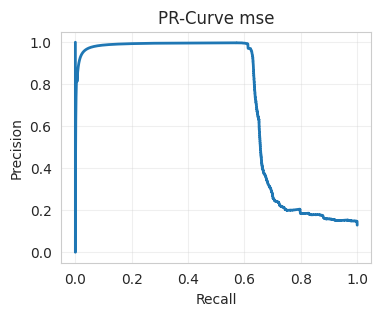




####################################################################################################
EVALUATING WITH IQR ANOMALY SCORE
####################################################################################################


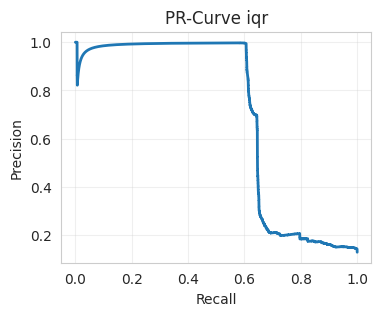




####################################################################################################
EVALUATING WITH MAHA ANOMALY SCORE
####################################################################################################


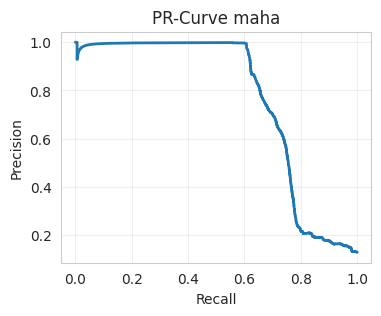



Training SWAT_Attention_LSTM
[SWAT_Attention_LSTM] Trainable params: 145,253
Training...
Epoch [1/30]  Train Loss: 0.006920, Val Loss: 0.002800
Epoch [2/30]  Train Loss: 0.001187, Val Loss: 0.002477
Epoch [3/30]  Train Loss: 0.000826, Val Loss: 0.002286
Epoch [4/30]  Train Loss: 0.000634, Val Loss: 0.002182
Epoch [5/30]  Train Loss: 0.000442, Val Loss: 0.001650
Epoch [6/30]  Train Loss: 0.000481, Val Loss: 0.001455
Epoch [7/30]  Train Loss: 0.000304, Val Loss: 0.001279
Epoch [8/30]  Train Loss: 0.000261, Val Loss: 0.001298
Epoch [9/30]  Train Loss: 0.000267, Val Loss: 0.001012
Epoch [10/30]  Train Loss: 0.000217, Val Loss: 0.000943
Epoch [11/30]  Train Loss: 0.000175, Val Loss: 0.000880
Epoch [12/30]  Train Loss: 0.000196, Val Loss: 0.001140
Epoch [13/30]  Train Loss: 0.000157, Val Loss: 0.000883
Epoch [14/30]  Train Loss: 0.000150, Val Loss: 0.000902
Epoch [15/30]  Train Loss: 0.000140, Val Loss: 0.000928
Epoch [16/30]  Train Loss: 0.000149, Val Loss: 0.000907
Epoch [17/30]  Train L

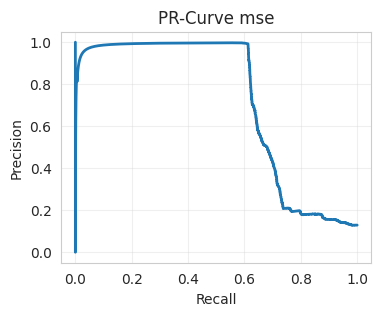




####################################################################################################
EVALUATING WITH IQR ANOMALY SCORE
####################################################################################################


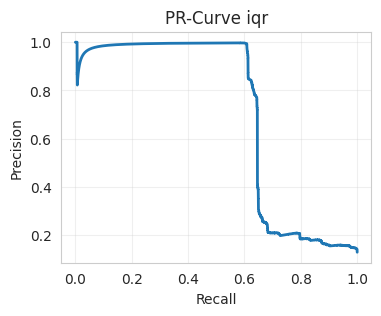




####################################################################################################
EVALUATING WITH MAHA ANOMALY SCORE
####################################################################################################


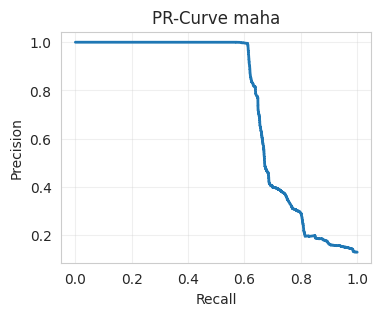



Training SWAT_LSTM_VAE
[SWAT_LSTM_VAE] Trainable params: 141,093
Training...
Epoch [1/30]  Train: total=0.056396 (rec=0.042729, kl=0.013666, β·kl=0.013666)  Val:   total=0.054773 (rec=0.036300, kl=0.018473, β·kl=0.018473)
Epoch [2/30]  Train: total=0.051377 (rec=0.032307, kl=0.019070, β·kl=0.019070)  Val:   total=0.053183 (rec=0.034373, kl=0.018810, β·kl=0.018810)
Epoch [3/30]  Train: total=0.050308 (rec=0.031929, kl=0.018378, β·kl=0.018378)  Val:   total=0.051480 (rec=0.033841, kl=0.017638, β·kl=0.017638)
Epoch [4/30]  Train: total=0.050558 (rec=0.031231, kl=0.019327, β·kl=0.019327)  Val:   total=0.050998 (rec=0.032636, kl=0.018362, β·kl=0.018362)
Epoch [5/30]  Train: total=0.050125 (rec=0.031172, kl=0.018953, β·kl=0.018953)  Val:   total=0.052382 (rec=0.032786, kl=0.019596, β·kl=0.019596)
Epoch [6/30]  Train: total=0.050200 (rec=0.030526, kl=0.019674, β·kl=0.019674)  Val:   total=0.050269 (rec=0.030410, kl=0.019859, β·kl=0.019859)
Epoch [7/30]  Train: total=0.049222 (rec=0.028891, 

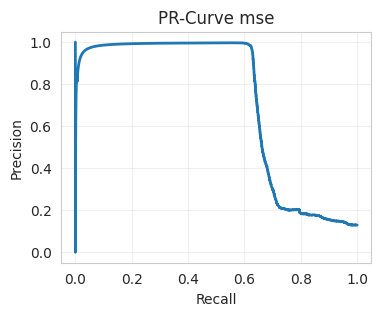




####################################################################################################
EVALUATING WITH IQR ANOMALY SCORE
####################################################################################################


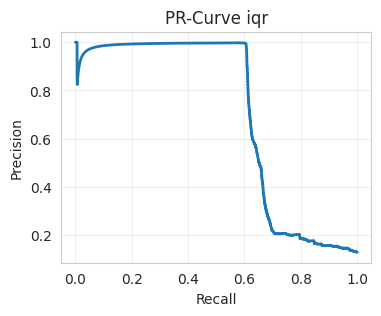




####################################################################################################
EVALUATING WITH MAHA ANOMALY SCORE
####################################################################################################


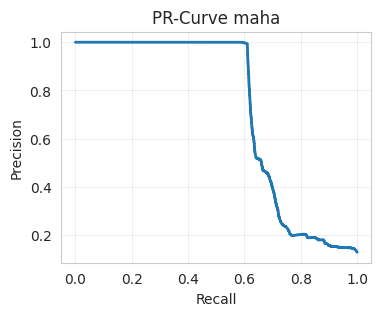



Training SWAT_Attn_LSTM_VAE
[SWAT_Attn_LSTM_VAE] Trainable params: 174,565
Training...
Epoch [1/30]  Train: total=0.055088 (rec=0.040249, kl=0.014839, β·kl=0.014839)  Val:   total=0.054825 (rec=0.036275, kl=0.018550, β·kl=0.018550)
Epoch [2/30]  Train: total=0.050670 (rec=0.032333, kl=0.018336, β·kl=0.018336)  Val:   total=0.051069 (rec=0.031328, kl=0.019740, β·kl=0.019740)
Epoch [3/30]  Train: total=0.050306 (rec=0.031042, kl=0.019264, β·kl=0.019264)  Val:   total=0.051537 (rec=0.031419, kl=0.020118, β·kl=0.020118)
Epoch [4/30]  Train: total=0.049752 (rec=0.030394, kl=0.019358, β·kl=0.019358)  Val:   total=0.051385 (rec=0.031958, kl=0.019428, β·kl=0.019428)
Epoch [5/30]  Train: total=0.049622 (rec=0.030004, kl=0.019618, β·kl=0.019618)  Val:   total=0.051143 (rec=0.031825, kl=0.019319, β·kl=0.019319)
Epoch [6/30]  Train: total=0.049375 (rec=0.029425, kl=0.019949, β·kl=0.019949)  Val:   total=0.051761 (rec=0.031281, kl=0.020480, β·kl=0.020480)
Epoch [7/30]  Train: total=0.049246 (rec=

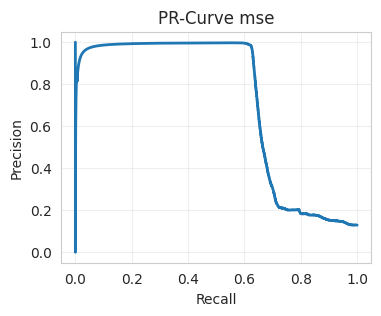




####################################################################################################
EVALUATING WITH IQR ANOMALY SCORE
####################################################################################################


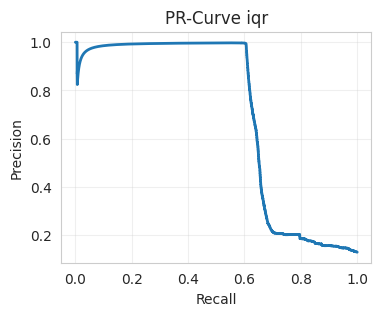




####################################################################################################
EVALUATING WITH MAHA ANOMALY SCORE
####################################################################################################


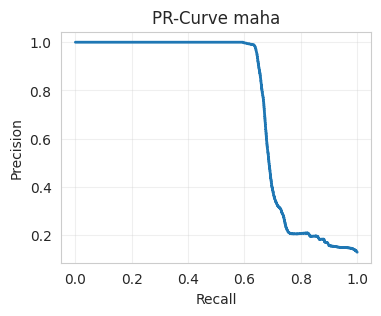




FINAL RESULTS: AVERAGED OVER CHANNELS
Model                Metric P        R        F1       ROC-AUC  PR-AUC    
--------------------------------------------------------------------------------
Baseline_LSTM        MSE    0.970    0.622    0.758    0.811    0.709535  
Baseline_LSTM        IQR    0.994    0.606    0.753    0.799    0.696090  
Baseline_LSTM        MAHA   0.994    0.607    0.754    0.852    0.763828  
Attention_LSTM       MSE    0.993    0.612    0.757    0.811    0.713295  
Attention_LSTM       IQR    0.994    0.608    0.755    0.803    0.700159  
Attention_LSTM       MAHA   0.995    0.611    0.757    0.840    0.738860  
LSTM_VAE             MSE    0.983    0.623    0.762    0.804    0.711589  
LSTM_VAE             IQR    0.995    0.606    0.753    0.798    0.697403  
LSTM_VAE             MAHA   0.993    0.610    0.756    0.819    0.717302  
Attn_LSTM_VAE        MSE    0.982    0.624    0.763    0.805    0.712588  
Attn_LSTM_VAE        IQR    0.995    0.606    0.753  

In [83]:
# ======================== Main Execution ========================
class Config:
    # 'SWAT' / 'SMAP' / 'MSL'
    DATASET   = 'SWAT'
    # DATASET   = 'SMAP'

    MODE = 'train'     # 'train'：train models 'test'：only test, no save
    LOAD_RUN = None    # in train mode, set LOAD_RUN = None

    # MODE = 'test'
    # LOAD_RUN = "/content/drive/MyDrive/Colab Notebooks/P_Models/SWAT_res01"


    # VIS_FEATURES = ['FIT301', 'LIT101', 'MV101', 'P101']  # plot features
    VIS_FEATURES = ['LIT101']  # plot features
    VIS_WINDOW_RANGE = 1000
    VIS_WINDOW_SEQ = 6

    SAVE_CKPT = True # if save model
    SAVE_ARTIFACTS = True # if save result

    VAE_BETA = 1.0    # KL （Beta-VAE）
    VAE_DETERMINISTIC_EVAL = False  # when evaluate, use mu downsampling


    DATA_DIR  = Path("/content/drive/MyDrive/Colab Notebooks/P_Dataset")
    SEQ_LEN   = 100
    STRIDE    = 1
    BATCH_SIZE= 64
    HIDDEN_DIM= 64
    NUM_LAYERS= 2
    DROPOUT   = 0.2
    LEARNING_RATE = 1e-3
    NUM_EPOCHS    = 30
    PATIENCE      = 15
    GRADIENT_CLIP = 1.0
    REMOVE_HOURS  = 5   # only SWAT use
    SEED          = 0
    VAL_SPLIT     = 0.2
    THR_STEP = 1000
    ANOMALY_METRICS = ['mse', 'iqr', 'maha']

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def adjust_for_dataset(cfg: Config):
    if cfg.DATASET.upper() in ('SMAP', 'MSL'):
        config.SAVE_CKPT = False
        config.SAVE_ARTIFACTS = False
        cfg.SEQ_LEN = 50    # MSL,SMAP, set SEQ_LEN = 50
        cfg.REMOVE_HOURS = 0


config = Config()
print(f"Using device: {config.DEVICE}")

# ======================== Set Random Seeds ========================
def set_seed(seed=config.SEED):
    """Set all random seeds for reproducibility"""
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

def main():
    adjust_for_dataset(config)
    print(f'Running Dataset:{config.DATASET}\n')

    datasets = load_dataset(config)
    all_model_results, all_model_stats = {}, {}
    global_scores, global_labels = [], []

    # Create save dir
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    if config.MODE == 'train':
        if config.SAVE_ARTIFACTS:   # only save SWAT
            run_dir = Path("/content/drive/MyDrive/Colab Notebooks/P_Models") / \
                    f"{config.DATASET}_{timestamp}_seed{config.SEED}"
            run_dir.mkdir(parents=True, exist_ok=True)
        else:
            run_dir = None

    for ds_name, (X_tr, X_te, y_te, scaler, feat_cols) in datasets.items():
    # print(f"\n=== Now training on [{ds_name}] ===")
        input_dim = X_tr.shape[1]          # SWaT=51, NASA=1

        models = {
            'Baseline_LSTM': LSTMAutoencoder(
                input_dim, config.HIDDEN_DIM, config.NUM_LAYERS,
                config.SEQ_LEN, dropout=config.DROPOUT).to(config.DEVICE),

            'Attention_LSTM': AttentionLSTMAutoencoder(
                input_dim, config.HIDDEN_DIM, config.NUM_LAYERS,
                config.SEQ_LEN, dropout=config.DROPOUT).to(config.DEVICE),

            'LSTM_VAE': LSTMVAE(
                input_dim, config.HIDDEN_DIM, config.NUM_LAYERS, config.SEQ_LEN,
                dropout=config.DROPOUT, use_init_state=True,
                deterministic_eval=config.VAE_DETERMINISTIC_EVAL
            ).to(config.DEVICE),

            'Attn_LSTM_VAE': AttentionLSTMVAE(
                input_dim, config.HIDDEN_DIM, config.NUM_LAYERS, config.SEQ_LEN,
                dropout=config.DROPOUT, use_init_state=True,
                deterministic_eval=config.VAE_DETERMINISTIC_EVAL
            ).to(config.DEVICE),
        }

        for mdl_name, mdl in models.items():
            res, stats = train_and_evaluate_model(
                f"{ds_name}_{mdl_name}", mdl, X_tr, X_te, y_te, config, run_dir=run_dir)

            for metric in res:
                if not metric.startswith('_'):
                    res[metric]['chan_id'] = ds_name

            all_model_results.setdefault(mdl_name, []).append(res)
            all_model_stats.setdefault(mdl_name,  []).append(stats)

            # NASA
            if config.DATASET.upper() in ('MSL', 'SMAP'):
                global_scores.append(res['_raw_scores'])
                global_labels.append(res['_raw_labels'])

    # print all results
    average_results = {}
    best_summary = {}  # key = (model, metric) -> lists

    for mdl, res_list in all_model_results.items():
        for idx, rs in enumerate(res_list):
            for m, out in rs.items():
                if m.startswith('_'):    # skip '_ data'
                    continue

                if 'pr_f1' not in out:
                    continue
                key = (mdl, m)
                if key not in best_summary:
                    best_summary[key] = {
                    'P': [], 'R': [], 'F1': [], 'AP': [], 'tau': [], 'auc':[]
                }
                best_summary[key]['P'].append(out['pr_precision'])
                best_summary[key]['R'].append(out['pr_recall'])
                best_summary[key]['F1'].append(out['pr_f1'])
                best_summary[key]['auc'].append(out['auc'])
                best_summary[key]['AP'].append(out['pr_auc'])
                best_summary[key]['tau'].append(out['pr_thr'])


    print("\n\n" + "="*100)
    print("FINAL RESULTS: AVERAGED OVER CHANNELS")
    print("="*100)
    print(f"{'Model':<20} {'Metric':<6} {'P':<8} {'R':<8} {'F1':<8} {'ROC-AUC':<8} {'PR-AUC':<10}")
    print("-"*80)
    for (mdl, m), vals in best_summary.items():
        avgP  = np.mean(vals['P'])
        avgR  = np.mean(vals['R'])
        avgF1 = np.mean(vals['F1'])
        avgROC = np.mean(vals['auc'])
        avgPR = np.mean(vals['AP'])
        print(f"{mdl:<20} {m.upper():<6} {avgP:<8.3f} {avgR:<8.3f} {avgF1:<8.3f} {avgROC:<8.3f} {avgPR:<10.6f}")

if __name__ == "__main__":
    main()